In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import re
import pickle
from matplotlib import pyplot as plt
from sklearn import datasets, neighbors, linear_model, model_selection, svm
from sklearn.model_selection import train_test_split,KFold,learning_curve, LeavePOut,GridSearchCV

# import private libraries
import src.utils as utils

/Users/zachwener/code/crmo-diagnosis-using-mri/src/utils.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use("TkAgg")


## Feature Extraction

### Load Existing Data

In [2]:
train_data = pickle.load(open( "train_data.pkl", "rb"))
test_data = pickle.load(open( "test_data.pkl", "rb"))

#### Baseline

This baseline builds a feature set by pulling pairs of images and creating a difference of the image histograms they produce. The assumption is that files are contained in some input directory in the form patientX-1.jpg, patientX-2.jpg

#### Create new data pickle

In [14]:
input_csv = pd.read_csv("data.csv")

In [23]:
def hist_features(img_path):
    img = cv2.imread(img_path, 0)
    # Based on my research 256 is the value to use for full range
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    return hist.flatten()

def baseline_hist_diff(img_before, img_after):
    return hist_features(img_before) - hist_features(img_after)

In [24]:
FILE_EXTENSION = "tif"
dir_name = "legs_folder/"

img_hist = []
patient_ids = []
Y = []

for index, row in input_csv.iterrows():
    patient_id = str(row["patient_id"])
    file_1 = os.path.join(dir_name, patient_id, '.'.join((row["scan_1"], FILE_EXTENSION)))
    file_2 = os.path.join(dir_name, patient_id, '.'.join((row["scan_2"], FILE_EXTENSION)))
    
    if not (os.path.isfile(file_1) and os.path.isfile(file_2)):
        continue
    Y.append(row["y"])
    
    # Skip if the file does not exist (due to poor quality)
    
    patient_ids.append(patient_id)
    diff = baseline_hist_diff(file_1, file_2)
    img_hist.append(diff)

column_names = ["hist" + str(i) for i in range(256)]
df = pd.DataFrame(img_hist, columns=column_names, index=patient_ids)
df["y"] = Y

data = df.loc[:, (df != 0).any(axis=0)]

# Split the data into training set and test set.
# DONT look at what is in the test set
test_patient_ids = ['2','32','24','24b','6','7', '41']
test_data = data.loc[test_patient_ids]
train_data = data.loc[data.index.difference(test_patient_ids)]

pickle.dump(train_data, open("train_data.pkl", "wb") )
pickle.dump(test_data, open("test_data.pkl", "wb") )

In [30]:
train_data

,hist0,hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8,hist9,...,hist247,hist248,hist249,hist250,hist251,hist252,hist253,hist254,hist255,y
1,3958.0,6050.0,3485.0,1560.0,553.0,367.0,211.0,151.0,88.0,122.0,...,-23.0,-24.0,-17.0,-17.0,-18.0,-13.0,-11.0,-19.0,-605.0,S
1,3958.0,6050.0,3485.0,1560.0,553.0,367.0,211.0,151.0,88.0,122.0,...,-9.0,-9.0,-8.0,-10.0,-13.0,-9.0,-9.0,-5.0,-927.0,S
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,15.0,9.0,7.0,5.0,4.0,2.0,14.0,-322.0,S
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.0,-4.0,-7.0,-3.0,0.0,4.0,-2.0,-1.0,452.0,R
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,5.0,8.0,5.0,-2.0,2.0,5.0,2.0,354.0,I
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,12.0,3.0,3.0,5.0,2.0,15.0,211.0,S
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.0,1.0,1.0,0.0,-2.0,-4.0,2.0,-2.0,-84.0,I
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,-5.0,0.0,0.0,-1.0,3.0,-4.0,4.0,-63.0,R
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-3.0,-2.0,-3.0,-4.0,0.0,-7.0,0.0,-104.0,R
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,-4.0,-2.0,-3.0,-2.0,4.0,-4.0,4.0,-5.0,R


In [3]:
X = train_data.drop('y', axis=1)
y = train_data["y"]

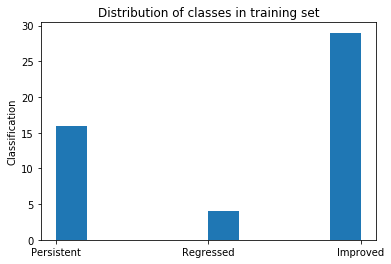

In [7]:
# Plot distribution of datapoints
# Suvadip suggested trying a binary classifier by combining regressed and persistent into one class.
# Then use ROC curve (used in binary classification) to evaluate model
plt.title('Distribution of classes in training set')
plt.ylabel('Classification')
ind = np.arange(3)
plt.xticks(ind, ('Persistent', 'Regressed','Improved'))
plt.hist(y.tolist())
plt.show()

### Do baseline prediction with logistic regression

In [43]:
X = train_data.drop('y', axis=1)
y = train_data["y"]

In [5]:
# This is based on recommendation from Suvadip. Leave one out is used for VERY small samples (size 15-20)
lpo = LeavePOut(3)

In [9]:
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000,
                                       multi_class='multinomial')
logistic_scores = model_selection.cross_val_score(logistic, X, y, cv=lpo, n_jobs=-1)

print('LogisticRegression score: %f' % np.mean(logistic_scores))
pickle.dump(train_data, open("train_data.pkl", "wb") )

LogisticRegression score: 0.488548


In [10]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3) # KNN might be biased becuase we are re-using data pairs?

knn_scores = model_selection.cross_val_score(knn, X, y, cv=lpo, n_jobs=-1)
print('KNN score: %f' % np.mean(knn_scores))

KNN score: 0.608626


In [77]:
from sklearn.tree import DecisionTreeClassifier 

# training a DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2)

results = model_selection.cross_val_score(dtree_model, X, y, cv=lpo)

# change to leave 2-3 out
# merge persist and regressed into 1 (ROC curve)
# on small dataset accuracy doesnt make sense
print('LPO Cross validation score DT: %f' % np.mean(results))

kf = KFold(n_splits=5)

results = model_selection.cross_val_score(dtree_model, X, y, cv=kf)
print('5-Fold Cross validation score DT: %f' % np.mean(results))

LPO Cross validation score DT: 0.505536
5-Fold Cross validation score DT: 0.431111


In [78]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()

results = model_selection.cross_val_score(dtree_model, X, y, cv=lpo)
print('LPO cross validation score Naive Bayes: %f' % np.mean(results))

LPO cross validation score Naive Bayes: 0.503908


# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1000, 'penalty': 'l1'}

Grid scores on development set:

0.503 (+/-0.558) for {'C': 0.001, 'penalty': 'l1'}
0.464 (+/-0.558) for {'C': 0.001, 'penalty': 'l2'}
0.527 (+/-0.562) for {'C': 0.01, 'penalty': 'l1'}
0.467 (+/-0.556) for {'C': 0.01, 'penalty': 'l2'}
0.519 (+/-0.568) for {'C': 0.1, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 0.1, 'penalty': 'l2'}
0.497 (+/-0.565) for {'C': 1, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 1, 'penalty': 'l2'}
0.490 (+/-0.567) for {'C': 10, 'penalty': 'l1'}
0.468 (+/-0.557) for {'C': 10, 'penalty': 'l2'}
0.531 (+/-0.556) for {'C': 100, 'penalty': 'l1'}
0.468 (+/-0.558) for {'C': 100, 'penalty': 'l2'}
0.547 (+/-0.564) for {'C': 1000, 'penalty': 'l1'}
0.468 (+/-0.557) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-s

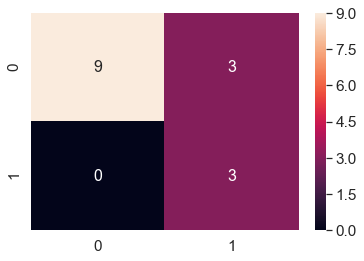

In [66]:
params = [{'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}]
lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'), cv=lpo, param_grid = params)
utils.do_CV(X,y, lr, multi_class=False)
pickle.dump(lr, open("lr_binary_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.402 (+/-0.538) for {'C': 0.001}
0.410 (+/-0.552) for {'C': 0.01}
0.412 (+/-0.552) for {'C': 0.1}
0.413 (+/-0.553) for {'C': 1}
0.398 (+/-0.547) for {'C': 10}
0.393 (+/-0.543) for {'C': 100}
0.395 (+/-0.543) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           I       0.71      0.42      0.53        12
           R       0.25      1.00      0.40         1
           S       0.00      0.00      0.00         2

   micro avg       0.40      0.40      0.40        15
   macro avg       0.32      0.47      0.31        15
weighted avg       0.59      0.40      0.45        15




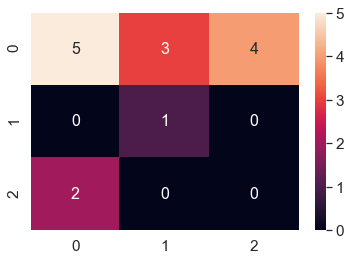

In [76]:
params = [{'C': [0.001,0.01,0.1,1,10,100,1000]}]
lr2 = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs', penalty='l2', multi_class="multinomial", max_iter=3000), cv=lpo, param_grid = params)
utils.do_CV(X,y, lr2, multi_class=True)

pickle.dump(lr2, open("lr_multi_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


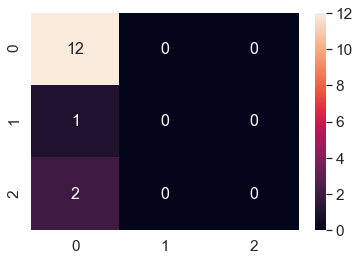

In [74]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

In [7]:
def plot_learning_curve(model, X,y, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y,
                                                            train_sizes=[5,10,15,20,25,30,35,40,45,48],
                                                            cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

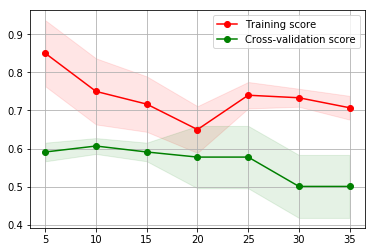

In [49]:
plot_learning_curve(knn, X,y, 4)

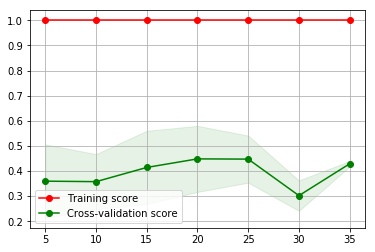

In [51]:
plot_learning_curve(logistic, X,y, 3)

In [ ]:
#pytorch
#pretrained embeddings
# extract a feature vector for any image with pytorch

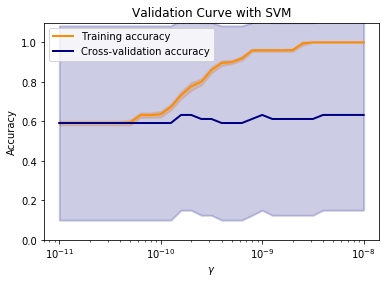

In [5]:
loo = model_selection.LeaveOneOut()
param_range = np.logspace(-11, -8, 31)

utils.generate_validation_curve(svm.SVC(), X, y, param_name="gamma", param_range=param_range,
                                cv=loo, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with SVM", xlabel="$\gamma$")

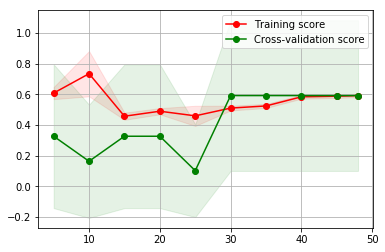

In [8]:
svm_classifier = svm.SVC(gamma=1e-11)
plot_learning_curve(svm_classifier, X,y, cv=loo)

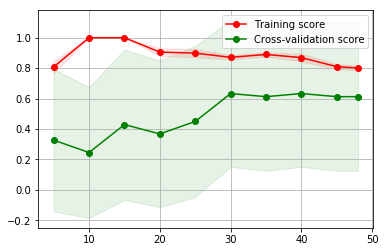

In [9]:
svm_classifier = svm.SVC(gamma=2.51188643e-10)
plot_learning_curve(svm_classifier, X,y, cv=loo)

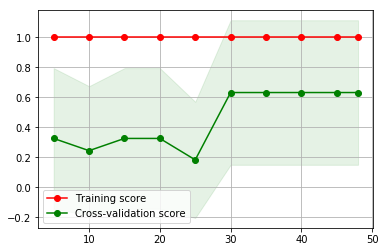

In [10]:
svm_classifier = svm.SVC(gamma=1e-8)
plot_learning_curve(svm_classifier, X,y, cv=loo)

### Attempting Interesting ORB points

In [11]:
dataset_path = 'leg_only'
img_building = cv2.imread(os.path.join(dataset_path, '16-1.tif'))
#img_building = cv2.cvtColor(img_building, cv2.COLOR_BGR2RGB)  # Convert from cv's BRG default color order to RGB

orb = cv2.ORB_create()  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.
key_points, description = orb.detectAndCompute(img_building, None)
img_building_keypoints = cv2.drawKeypoints(img_building, 
                                           key_points, 
                                           img_building, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
plt.figure(figsize=(16, 16))
plt.title('ORB Interest Points')
plt.imshow(img_building_keypoints); plt.show()

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/features2d/src/draw.cpp:115: error: (-215:Assertion failed) !outImage.empty() in function 'drawKeypoints'


In [4]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(dataset_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()
    

orb = cv2.ORB_create()
draw_image_matches(orb, '7a-1.tif', '7a-2.tif')

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [5]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img_building, None)
img_kp = cv2.drawKeypoints(img_building, kp, img_building)

plt.figure(figsize=(15, 15))
plt.imshow(img_kp); plt.show()

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/opencv_contrib-3.4.2/modules/xfeatures2d/src/sift.cpp:1121: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'
